# Data setup

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, multivariate_normal
from autograd import grad
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import gpytorch
import torch
import os
import theano
import pymc3 as pm
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline


In [2]:
def sigma_fn(c, w_0=0.5, w_1=7):
    return w_0 ** 2 + (w_1 ** 2) * c

def sigma_dw_0(c, w_0, w_1):
    return 2 * w_0

def sigma_dw_1(c, w_0, w_1):
    return 2 * w_1 * c


def gamma_fn(c, w_0=0.1, w_1=0.5):
    return w_0 ** 2 + (w_1 ** 2) * c

def gamma_dw_0(c, w_0, w_1):
    return 2 * w_0

def gamma_dw_1(c, w_0, w_1):
    return 2 * w_1 * c

num_samples = 10000
x = np.array([3])

c = np.random.rand(num_samples)
sigma_2 = 1/gamma_fn(c)

eps = []

for sigma in sigma_2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
y = x + eps

/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


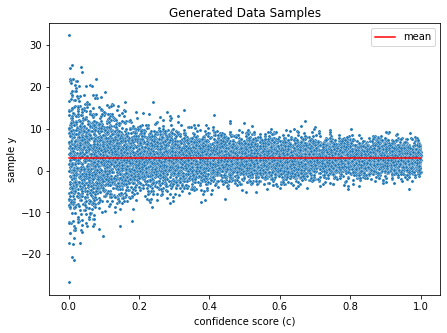

In [3]:
plt.figure(figsize=(7, 5))
sns.scatterplot(c, y, s=10)

# Bigger c value = more variance/uncertainty
plt.xlabel('confidence score (c)')
plt.ylabel('sample y')
plt.title("Generated Data Samples")
plt.plot([0, 1], [y.mean(), y.mean()], 'r', label='mean')
plt.legend(loc='upper right');

In [4]:
y[c < 0.1].std(), y[c > 0.9].std()

(7.410248515437843, 2.0633175482283512)

# 1.1: Frequentist approach

In [5]:
def l_dmu(mu, w_0, w_1):
    return ((y - mu) / sigma_fn(c, w_0, w_1)).sum()

def l_dw0(mu, w_0, w_1):
    return 0.5 * ((y - mu) ** 2 / (sigma_fn(c, w_0, w_1) ** 2) * sigma_dw_0(c, w_0, w_1)
            - (sigma_dw_0(c, w_0, w_1) / sigma_fn(c, w_0, w_1))).sum()

def l_dw1(mu, w_0, w_1):
    return 0.5 * ((y - mu) ** 2 / (sigma_fn(c, w_0, w_1) ** 2) * sigma_dw_1(c, w_0, w_1)
            - (sigma_dw_1(c, w_0, w_1) / sigma_fn(c, w_0, w_1))).sum()
def l_jac(params):
    mu, w_0, w_1 = params
    return - np.array([l_dmu(mu, w_0, w_1),
                     l_dw0(mu, w_0, w_1),
                     l_dw1(mu, w_0, w_1),
                    ])
def log_fn(params):
    mu = params[0]
    w_0 = params[1]
    w_1 = params[2]
    
    first = (y - mu) ** 2 / sigma_fn(c, w_0=w_0, w_1=w_1)
    second = np.log(sigma_fn(c, w_0=w_0, w_1=w_1))
    return first.sum() + second.sum()

In [6]:
mu_mle, w0_mle, w1_mle = minimize(log_fn, [3, 0.5, 7], jac=l_jac, method='Newton-CG').x
mu_mle, w0_mle, w1_mle

(2.9739181709718934, 3.7208174981464404, 6.171689961769245e-11)

In [7]:
mu_mle = minimize(log_fn, [3, 0.5, 7], jac=l_jac, method='Newton-CG').x

### Vicente Code

In [8]:
# def tanh(x,z):
    
#     y = np.exp(-2.0*x*z)
#     return (1.0 - y) / (1.0 + y)


# def plano(x, param):
    
    
#     return x[0]+2*x[1]+param

# x = np.linspace(-7, 7, 200)

# grad(plano)(np.array([0.4, 0.3]), 0.5)


L = 20.0

def S(tau, theta):
    
    return theta[0]*np.exp(tau**2/theta[1])

def Lambda(n,L):
    return (n+1)*np.pi/(2*L)

def gamma_plus(i,j,L):
    
    return Lambda(i,L) + Lambda(j,L)

def gamma_minus(i,j,L):
    
    return Lambda(i,L) - Lambda(j,L)

# def psi(x,i,j,L):
    
#     if i==j:
        
#         return 1/(2*L)*(x+L) - np.sin(gamma_plus(j,j,L)*(x+L) )/(2*L*gamma_plus(j,j,L))
    
#     else:
        
#          return np.sin(gamma_minus(i,j,L)*(x+L) )/(2*L*gamma_minus(i,j,L)) - np.sin(gamma_plus(i,j,L)*(x+L) )/(2*L*gamma_plus(i,j,L))

        
def psi(x,i,j,L):
    
    if i==j:
        
        t1 = 1/(2*L)*x
        t2 = np.sin(gamma_plus(j,j,L)*(x+L) )/(2*L*gamma_plus(j,j,L)) - np.sin(gamma_plus(j,j,L)*(L) )/(2*L*gamma_plus(j,j,L))
        
        return t1 - t2
    
    else:
        
        t1 = np.sin(gamma_minus(i,j,L)*(x+L) )/(2*L*gamma_minus(i,j,L)) - np.sin(gamma_minus(i,j,L)*(L) )/(2*L*gamma_minus(i,j,L))
        t2 = np.sin(gamma_plus(i,j,L)*(x+L) )/(2*L*gamma_plus(i,j,L)) - np.sin(gamma_plus(i,j,L)*(L) )/(2*L*gamma_plus(i,j,L))

        return t1 - t2

        
def Psi(x,L, N):

    MPsi = np.zeros((N,N))
    for i in range(0,N):
        for j in range(0,N):
            MPsi[i,j] = psi(x,i,j,L)
            
    return MPsi
        

def g(x, f_0, alpha):
    
    MPsi = Psi(x,L, len(alpha))
    
    return f_0 + alpha.T@ (MPsi@alpha)


### def f(x, f_0, alpha):
    
#     N = len(alpha)
    
#     #MPsi = Psi(x,L, N)
    
#     quad = 0
    
    
#     for i in range(0,N):
#         for j in range(0,N):
#             quad = psi(x,i,j,L) * alpha[i] * alpha[j]
    
    
#     return f_0 + quad#alpha.T@ (MPsi@alpha)


def f(x, f_0, alpha, MPsi):
    
#     N = len(alpha)
    
    #MPsi = Psi(x,L, N)
    
#     quad = 0
    
    
#     for i in range(0,N):
#         for j in range(0,N):
#             quad = psi(x,i,j,L) * alpha[i] * alpha[j]
    
    
    return f_0 + alpha.T@ (MPsi@alpha)


    
def Pre_Mat(N, theta):
    
    u = np.zeros(N)
    
    for i in range(N):
        
        u[i] = 1/S(Lambda(i, L), theta)
        
    return np.diag(u)


def ker(x,y):
    
    return 1.0 +x*y*0


def log_likelihood(f_0, alpha, Y, X, C, mu, MPsi):
    
#     f_0 = beta[0]
#     alpha = beta[1:]
  
    l = 0
    
    for i in range(len(Y)):
        

        sigma2 = f(C[i], f_0, alpha, MPsi[i])
        
                
        l += -( mu - Y[i]  )**2/sigma2 - np.log(sigma2)
    
    
    return l

def logp_f_0(log_f, theta1, theta2):
    
    f_0 = np.exp(log_f)
    
    #return - (f_0-theta1)**2/theta2
    
    
    return  (theta1 -1)*log_f - theta2*np.exp(log_f) #+ theta1*np.log(theta2) - np.log(gamma(theta1))

def logp_alpha(alpha, theta):
    
    
    l = 0
    
    for i in range(len(alpha)):
        
        if S(Lambda(i,L), theta) <= 0.0:
            print('Problema en S')
        
        l += -0.5*(alpha[i]**2/ S(Lambda(i,L), theta )) - 0.5*np.log(S(Lambda(i,L),theta ))
    
    return l


def logp_mu(mu):
    
    return -0.5*mu**2/1 - 0.5*np.log(1)


def log_p(beta, mu, theta1, theta2, theta, Y,X, C, MPsi):
    
    f_0 = np.exp(beta[0]) 
    alpha = beta[1:]
    
    return logp_mu(mu) + logp_alpha(alpha, theta)+ logp_f_0(beta[0], theta1, theta2)+log_likelihood(f_0, alpha, Y, X, C, mu, MPsi)


#Gaussian process in the param

def log_likelihood_GP(f_0, alpha, Y, K, C):
    
    f_0 = beta[0]
    alpha = beta[1:]
  

    
    D = np.zeros(len(C))
    

    for i in range(len(C)):
        #we add a little noise to the diagonal to ensure PD of the matrix
#         f(C[i], f_0, alpha)
#         print(A[i,i], i)
        e_i = np.zeros(len(C))
        e_i[i] = 1.0
        D += (f(C[i], f_0, alpha) + 0.0001)*e_i
        A[i,i] += 0.0001
    
    A = K + np.eye(len(C))*D
    
    
    
    x = np.linalg.solve(A, Y)
    
    
    return -0.5*np.dot(Y,x) - 0.5*np.log(np.linalg.det(A))
    


def log_p_GP(beta, theta1, theta2, theta, Y,K, C):
    
    f_0 = beta[0] 
    alpha = beta[1:]
    
    return logp_alpha(alpha, theta)+ logp_f_0(f_0, theta1, theta2)+log_likelihood_GP(f_0, alpha, Y, K, C)







In [9]:
# #Hyper Parameters
# import time

# t0 = time.time()

# theta1 = 0.0
# theta2 = 3.
# theta = np.array([20., 1.0])

# #Hyper mean

# mu = 3.1


# # Kernel of the GP

# K = np.zeros((num_samples, num_samples))

# for i in range(num_samples):
#     for j in range(num_samples):
#         K[i,j] = ker(X[i], X[j])


# beta_0 = np.array([0.4, 0.4, 1.0, 0.4, 0.4, 0.4, 0.5, 0.6, 1, 2]) +10
# N = len(beta_0) - 2


# MPsi = []

# for i in range(len(C)):
    
#     MPsi.append(Psi(C[i],L, N))

# to_opti = lambda beta: -log_p(beta[1:], beta[0], theta1, theta2, theta, Y, X, C, MPsi)


# nab_p = lambda beta: grad(to_opti)(beta)


# beta = minimize(to_opti, beta_0 , jac=nab_p, method='Newton-CG').x

# print(time.time() - t0)


## MCMC

In [10]:
alpha, sigma = 1, 1
beta = [1, 2.5]
size = 100
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

model = pm.Model()
with model:
    x0 = pm.Normal("x0", mu=0, sigma=10)
#     beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
#     sigma = pm.HalfNormal("sigma", sigma=1)
    theta1 = pm.Normal("theta1", mu=0, sigma=10)
    theta2 = pm.Normal("theta2", mu=0, sigma=10)
    
    # Expected value of outcome
    mu = alpha + theta1 * X1 + theta2 * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)




# with pm.Model() as m:
#     y = 3
#     step1 = pm.Metropolis([y])
#     trace = pm.sample(step=[step1])


# x = 1
# alpha = np.array(range(1,6))
# # g(1,5,alpha)
# MPsi = Psi(x,L, len(alpha))
# model = f_0 + alpha.T@ (MPsi@alpha)
pm.find_MAP(model=model)

{'x0': array(0.), 'theta1': array(1.09130205), 'theta2': array(2.51876526)}

In [11]:
### Metropolis-Hastings
with model: 
    step = pm.Metropolis()
    trace = pm.sample(500, step = step)

/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta2]
>Metropolis: [theta1]
>Metropolis: [x0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [12]:
### Hamiltonian
with model: 
    step = pm.HamiltonianMC()
    trace = pm.sample(500, step = step)

/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [theta2, theta1, x0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 11 seconds.


In [13]:
trace["x0"] + trace["theta1"] + trace["theta2"]

array([19.47734052, -0.51631207, -0.51631207, ...,  8.53368795,
       11.83479148,  6.85517792])

In [28]:
def second_aprox(Y, sigma2):
    
    pres = 1/sigma2
    
    tot = np.sum(pres)
    
    return 1/tot * np.dot(Y,pres)

def Psi(x,L, N):

    MPsi = np.zeros((N,N))
    for i in range(0,N):
        for j in range(0,N):
            MPsi[i,j] = psi(x,i,j,L)
            
    return MPsi


def f(x, f_0, alpha, MPsi):
    
#     N = len(alpha)
    
    #MPsi = Psi(x,L, N)
    
#     quad = 0
    
    
#     for i in range(0,N):
#         for j in range(0,N):
#             quad = psi(x,i,j,L) * alpha[i] * alpha[j]
    
    
    return f_0 + alpha.T@ (MPsi@alpha)



num_samples = 20
mu = 3
X = np.linspace(0,1, num_samples)

w_0 = 1.1
w_1 = 2
w = np.array([w_0, w_1]).squeeze()

exp_mean = np.zeros((5,15))
alg_mean = np.zeros((5,15))
good_mean = np.zeros((5,15))
second_alg = np.zeros((5,15))

K = np.ones((num_samples, num_samples))

beta_0 = np.array([0.4, 0.4, 1.0, 0.4]) + 10
# def ker(x,y):
    
#     return 1.0 +x*y*0

# for i in range(num_samples):
#     for j in range(num_samples):
#         K[i,j] = ker(X[i], X[j])



In [69]:
pm.Metropolis?
# pm.HamiltonianMC? 

In [29]:
alpha = mu_mle[1:]
L = 20.0
N = len(alpha)
num_samples = 100


for i in range(5):
    
    for j in range(15):
    
        good_points = 20*(i+1)

        C = np.concatenate(  (np.random.uniform(0.5, 1.5, size = good_points), np.random.uniform(2., 6., size = num_samples - good_points) ) )

        sigma2 = sigma_fn(C, *w)

        eps = []

        for sigma in sigma2:
            assert sigma > 0, f'Sigma is {sigma}'
            noise = norm(scale=sigma ** 0.5).rvs(1)
            eps.append(noise)

        eps = np.array(eps).squeeze()
        assert eps.shape == (num_samples,)
        Y = mu + eps
        
        exp_mean[i, j] = np.mean(Y) 
        good_mean[i,j] = np.mean(Y[0:good_points])
        
        
        MPsi = []

        for k in range(len(C)):
    
            MPsi.append(Psi(C[k],L, N))
#             MPsi.append(np.array([1]))
        
        to_opti = lambda beta: -log_p(beta[1:], beta[0], theta1, theta2, theta, Y, X, C, MPsi)


        nab_p = lambda beta: grad(to_opti)(beta)
        
        beta = minimize(log_fn, [3, 0.5, 7], jac=l_jac, method='Newton-CG').x
        
        aproximation = np.zeros(len(C))


        for l in range(num_samples):
    
            aproximation[l] = f(C[l], np.exp(beta[1]), np.array(beta[2:].tolist() * 2), MPsi[l])
    
        
        
        alg_mean[i,j] = beta[0]
        
        # alpha_alg[i,j,:] = beta[1:]
        
        second_alg[i,j] = second_aprox(Y, aproximation)

/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  app.launch_new_instance()


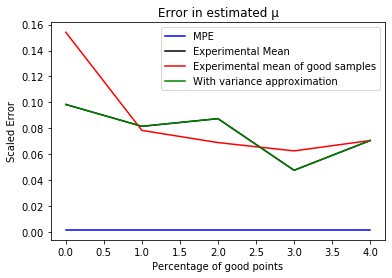

In [30]:
error_alg_20 = np.mean(np.absolute(alg_mean - mu)/mu, axis = 1)
error_exp_20 = np.mean(np.absolute(exp_mean - mu)/mu, axis = 1)
error_good_20 = np.mean(np.absolute(good_mean - mu)/mu, axis = 1)
error_second_20 = np.mean(np.absolute(second_alg - mu)/mu, axis = 1)


plt.plot(error_alg_20, c = 'b', label="MPE")
plt.plot(error_exp_20, c = 'k', label="Experimental Mean")
plt.plot(error_good_20, c = 'r', label="Experimental mean of good samples")
plt.plot(error_second_20, c = 'g', label="With variance approximation")

plt.xlabel("Percentage of good points")
plt.ylabel("Scaled Error")
plt.title("Error in estimated \u03BC")

plt.legend(loc = "top right")




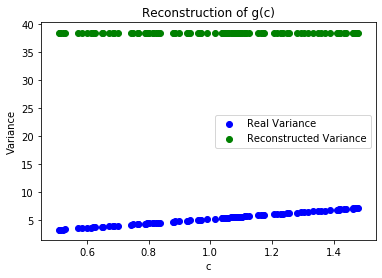

In [31]:
plt.scatter(C, sigma2, c='b', label="Real Variance")
plt.scatter(C, aproximation, c = 'g', label="Reconstructed Variance")
plt.xlabel("c")
plt.ylabel("Variance")
plt.title("Reconstruction of g(c)")
plt.legend()

In [32]:
# MPsi[l].reshape(1,4)
# alg_mean
# for l in range(num_samples):
#     print(C[l], np.exp(beta[1]), beta[2:], MPsi[l], "\n\n")

#    aproximation[l] = f(C[l], np.exp(beta[1]), beta[2:], MPsi[l].reshape(1,4).T)

# f(x, f_0, alpha, MPsi):
# f_0 + alpha.T@ (MPsi@alpha)

# C[0], np.exp(beta[1]), beta[2:], MPsi[0]
# np.array(beta[2:].tolist() * 2).T @ MPsi[0] @ np.array(beta[2:].tolist() * 2)
error_alg_20 = np.mean(np.absolute(alg_mean - mu)/mu, axis = 1)
error_alg_20

array([0.00161138, 0.00161138, 0.00161138, 0.00161138, 0.00161138])

# 1.2 Frequentist Regression

In [330]:
def Psi(x,L, N):

    MPsi = np.zeros((N,N))
    for i in range(0,N):
        for j in range(0,N):
            MPsi[i,j] = psi(x,i,j,L)
            
    return MPsi

def sigma_fn_2(c, v_0=0.5, v_1=7):
    return v_0 ** 2 + (v_1 ** 2) * c

def sigma_2_dv_0(c, v_0, v_1):
    return 2 * v_0

def sigma_2_dv_1(c, v_0, v_1):
    return 2 * v_1 * c



def gamma_fn_2(c, v_0=0.001, v_1=0.002):
    return v_0 ** 2 + (v_1 ** 2) * c

def gamma_2_dv_0(c, v_0, v_1):
    return 2 * v_0

def gamma_2_dv_1(c, v_0, v_1):
    return 2 * v_1 * c

def phi(x):
    return np.array([x ** 0, x, x ** 2]).squeeze()

num_samples = 1000

# x = np.random.randint(0, 101, size=num_samples)
# x = np.random.rand(num_samples)
x = np.linspace(-11,10, num_samples)

# c = np.zeros(num_samples)
c = np.random.rand(num_samples) 

# w_0 = 13
# w_1 = 0.9
# w_2 = 0.02
# v_0 = 0.01
# v_1 = 0

w_0 = 1.3
w_1 = 1.9
w_2 = 1.5
v_0 = 0.1
v_1 = 0.02


w = np.array([w_0, w_1, w_2]).squeeze()
v = np.array([v_0, v_1]).squeeze()
sigma_2 = 1/gamma_fn_2(c, v_0=v_0, v_1=v_1)

eps = []

for sigma in sigma_2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
# assert x.shape == (num_samples,)
y = w.T @ phi(x) + eps
y_true = w.T @ phi(x)
assert y.shape == (num_samples,)
assert y_true.shape == (num_samples,)

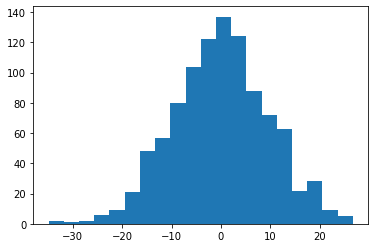

In [331]:
plt.hist(eps, bins=20);

Text(0, 0.5, 'sample y')

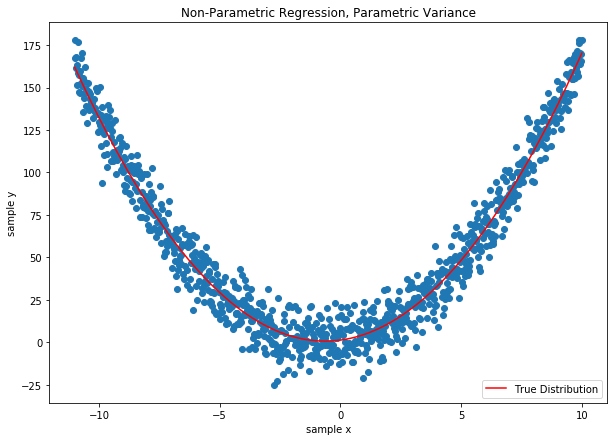

In [332]:
plt.figure(figsize=(10, 7))
plt.scatter(x, y)
plt.plot(x, y_true, 'r', label="True Distribution")
plt.legend(loc="lower right")
plt.title("Non-Parametric Regression, Parametric Variance")
plt.xlabel('sample x')
plt.ylabel('sample y')

In [333]:
Phi = phi(x)
P = 1/sigma_2 * np.eye(len(sigma_2))
P_inv = sigma_2 * np.eye(len(sigma_2))

def log_fn(params):
    w = params[0: 3]
    v = params[3: ]

    first = (w @ Phi - y) ** 2 * gamma_fn_2(c, *v)
    second = np.log(gamma_fn_2(c, *v))
    return 0.5 * (first.sum() - second.sum())


def l_deriv_w(w, v):
    # F_minus1 = np.linalg.inv(F(v))
    # result = Phi.T @ F_minus1 @ Phi @ w - Phi.T @ F_minus1 @ y
    # result = Phi.T @ ((w.T @ Phi - y) / sigma_fn_2(c, *v))
    result = Phi @ P @ (Phi.T @ w -  y)
    return result

def l_deriv_v0(w, v):
    first = (w @ Phi - y)**2 * gamma_2_dv_0(c, *v) 
    second = gamma_2_dv_0(c, *v) / gamma_fn_2(c, *v)
    return 0.5*(first.sum() - second.sum())

def l_deriv_v1(w, v):
    first = (w @ Phi - y)**2 * gamma_2_dv_1(c, *v) 
    second = gamma_2_dv_1(c, *v) / gamma_fn_2(c, *v)
    return 0.5*(first.sum() - second.sum())
def l_jac(params):
    w = params[0: 3]
    v = params[3: ]
    return  np.array([*l_deriv_w(w, v),
                       l_deriv_v0(w, v),
                       l_deriv_v1(w, v),
                       ])

In [334]:
# w_0 = 1
# w_1 = 1
# w_2 = 1+ h*1j
# h = 0.00001
# v_0 = 0.01 
# v_1 = 0.02

# w_0 = 1.3
# w_1 = 1.9
# w_2 = 1.5
# v_0 = 0.01
# v_1 = 0.02



# w = np.array([w_0, w_1, w_2]).squeeze()
# v = np.array([v_0, v_1]).squeeze()


# print(np.imag(log_fn(np.append(w,v))/h))

w_0 = 4
w_1 = 1
w_2 = 2
v_0 = 0.1
v_1 = 0.2

# w_0 = 1.3
# w_1 = 1.9
# w_2 = 1.5
# v_0 = 0.01
# v_1 = 0.02



w = np.array([w_0, w_1, w_2]).squeeze()
v = np.array([v_0, v_1]).squeeze()



# print(l_deriv_w(w,v))

w_start = np.array([w_0, w_1, w_2]).squeeze()
v_start = np.array([v_0, v_1]).squeeze()

print(l_jac(np.append(w_start,v_start)))

minimize(log_fn, np.append(w_start,v_start), jac=l_jac, method='Newton-CG')
#minimize(log_fn, np.append(w_start,v_start),method='Nelder-Mead')

[  221.50461981  -646.31773912 14183.77118261 85980.56902382
 89064.67159996]


     fun: 2764.4855353276994
     jac: array([ 2.95840182e-06, -3.10300672e-06,  4.49349237e-07, -1.56733214e-03,
       -2.51785078e-07])
 message: 'Optimization terminated successfully.'
    nfev: 40
    nhev: 0
     nit: 26
    njev: 336
  status: 0
 success: True
       x: array([ 9.65806795e-01,  1.93452223e+00,  1.50897983e+00, -1.03883465e-01,
       -3.01463299e-10])

/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


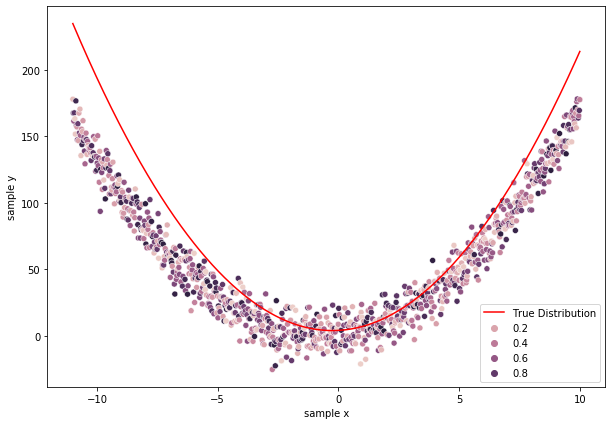

In [335]:
w_0_mle, w_1_mle, w_2_mle, v_0_mle, v_1_mle = minimize(log_fn, np.append(w_start,v_start), jac=l_jac, method='Newton-CG').x
#w_0_mle, w_1_mle, w_2_mle, v_0_mle, v_1_mle = minimize(log_fn, np.append(w_start,v_start),method='Nelder-Mead').x


w_mle = np.array([w_0_mle, w_1_mle, w_2_mle])
y_approx = w.T @ phi(x)


plt.figure(figsize=(10, 7))
sns.scatterplot(x,
                y,
                hue=c,
                )
plt.plot(x, y_approx, 'r', label="True Distribution")
plt.xlabel('sample x')
plt.ylabel('sample y')
plt.legend(loc='lower right');

In [336]:
mu_mle = minimize(log_fn, np.append(w_start,v_start), jac=l_jac, method='Newton-CG').x

In [337]:
alpha = mu_mle[1:]
L = 20.0
N = len(alpha)
num_samples = 100

for i in range(5):
    
    for j in range(15):
    
        good_points = 20*(i+1)

        C = np.concatenate(  (np.random.uniform(0.5, 1.5, size = good_points), np.random.uniform(2., 6., size = num_samples - good_points) ) )

        sigma2 = sigma_fn(C, *v)

        eps = []

        for sigma in sigma2:
            assert sigma > 0, f'Sigma is {sigma}'
            noise = norm(scale=sigma ** 0.5).rvs(1)
            eps.append(noise)

        eps = np.array(eps).squeeze()
        assert eps.shape == (num_samples,)
        Y = mu + eps
        
        exp_mean[i, j] = np.mean(Y) 
        good_mean[i,j] = np.mean(Y[0:good_points])
        
        
        MPsi = []

        for k in range(len(C)):
    
            MPsi.append(Psi(C[k],L, N))
#             MPsi.append(np.array([1]))
        
        to_opti = lambda beta: -log_p(beta[1:], beta[0], theta1, theta2, theta, Y, X, C, MPsi)


        nab_p = lambda beta: grad(to_opti)(beta)
        
        beta = minimize(log_fn, np.append(w_start,v_start), jac=l_jac, method='Newton-CG').x
        
        aproximation = np.zeros(len(C))


        for l in range(num_samples):
    
            aproximation[l] = f(C[l], np.exp(beta[0]), beta[1:], MPsi[l])
    
        
        
        alg_mean[i,j] = beta[0]
        
        # alpha_alg[i,j,:] = beta[1:]
        
        second_alg[i,j] = second_aprox(Y, aproximation)

/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  app.launch_new_instance()


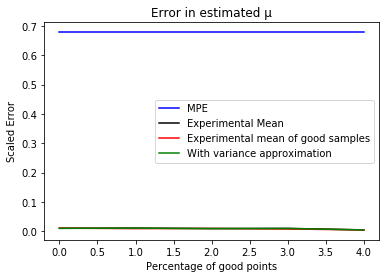

In [338]:
error_alg_20 = np.mean(np.absolute(alg_mean - mu)/mu, axis = 1)
error_exp_20 = np.mean(np.absolute(exp_mean - mu)/mu, axis = 1)
error_good_20 = np.mean(np.absolute(good_mean - mu)/mu, axis = 1)
error_second_20 = np.mean(np.absolute(second_alg - mu)/mu, axis = 1)


plt.plot(error_alg_20, c = 'b', label="MPE")
plt.plot(error_exp_20, c = 'k', label="Experimental Mean")
plt.plot(error_good_20, c = 'r', label="Experimental mean of good samples")
plt.plot(error_second_20, c = 'g', label="With variance approximation")

plt.xlabel("Percentage of good points")
plt.ylabel("Scaled Error")
plt.title("Error in estimated \u03BC")

plt.legend(loc = "top right")




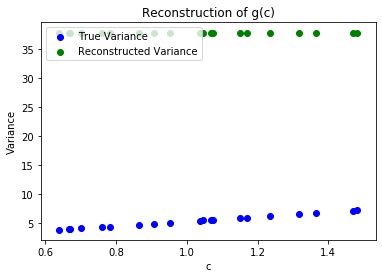

In [302]:
plt.scatter(C, sigma2, c='b', label = "True Variance")
plt.scatter(C, aproximation, c = 'g', label="Reconstructed Variance")
plt.xlabel("c")
plt.ylabel("Variance")
plt.title("Reconstruction of g(c)")
plt.legend(loc="upper left")

# 1.3 Bayesian approach

## Generate Sample Data
Data generated according to:
$$y = f(x) + \epsilon(c) \hspace{.3cm} f \sim GP(0,k)$$

For this example we will choose an RBF kernel

In [303]:
def Psi(x,L, N):

    MPsi = np.zeros((N,N))
    for i in range(0,N):
        for j in range(0,N):
            MPsi[i,j] = psi(x,i,j,L)
            
    return MPsi

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

n_samples = 100
    
test_x = torch.linspace(1, 100, n_samples)
    
### Make GP

likelihood = gpytorch.likelihoods.GaussianLikelihood()

RBF_kernel = gpytorch.kernels.RBFKernel()
RBF_kernel.has_lengthscale = True
RBF_kernel.lengthscale = 7.3
RBF_kernel = gpytorch.kernels.ScaleKernel(RBF_kernel)
RBF_model = ExactGPModel(None, None, likelihood, RBF_kernel)
RBF_model.covar_module.outputscale = 12.4
RBF_model.eval()


RBF_pred = RBF_model(test_x)
RBF_samples = RBF_pred.rsample(sample_shape=torch.Size([1]))



v_0 = 0.521
v_1 = 1.783
v = np.array([v_0, v_1]).squeeze()

### Make Sigma Values
#c = np.random.normal(size=n_samples)
c = np.random.rand(n_samples) 

print(np.min(c))

def sigma_fn_3(c, v_0=v_0, v_1=v_1):
    return v_0**2 + (v_1**2) * c

def gamma_fn_3(c, v_0=v_0, v_1=v_1):
    return v_0**2 + (v_1**2) * c

sigma2 = 1/gamma_fn_3(c, v_0, v_1)

### Make Sample Data
y = (RBF_samples.detach().numpy() + sigma2)[0]

0.007372036144997929


/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


(array([56., 16.,  8.,  7.,  5.,  1.,  4.,  1.,  1.,  1.]),
 array([0.29481626, 0.60445867, 0.91410108, 1.22374349, 1.5333859 ,
        1.84302831, 2.15267072, 2.46231313, 2.77195554, 3.08159795,
        3.39124036]),
 <a list of 10 Patch objects>)

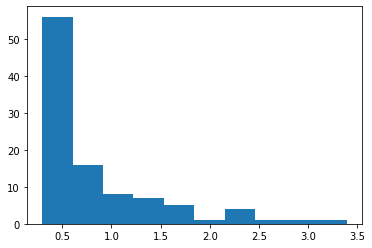

In [304]:
### Checking for Gaussian Noise
plt.hist(sigma2)

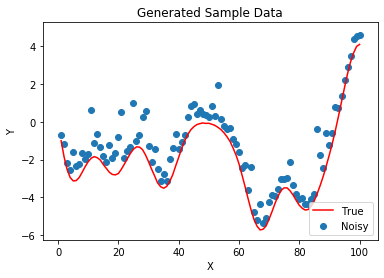

In [305]:
### Plotting Noisy Data vs. True Function
plt.plot(test_x, RBF_samples.detach().numpy()[0], 'r-', label="True")
plt.scatter(test_x, y, label="Noisy")
plt.title("Generated Sample Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="lower right")

## Derivative Equations

Marginal Likelihood: 
$$ \ell(\theta, v)  = \log p(y| \theta, v) = -\frac{1}{2} y^T(K_\theta + F)^{-1} y - \frac{1}{2} \log|K_\theta + F| - \frac{N}{2} \log(2 \pi) $$

$$\alpha =(K_\theta + F)^{-1}y $$


Derivative Equations: 
$$
\begin{align}
    \frac{\partial \ell}{\partial v_j} = \frac{1}{2} \text{tr}(\alpha \alpha^T  - (K_\theta + F)^{-1} \frac{\partial F}{\partial v_j}  ) \\
    \frac{\partial \ell}{\partial \theta_j} = \frac{1}{2} \text{tr}(\alpha \alpha^T  - (K_\theta + F)^{-1} \frac{\partial K_{\theta}}{\partial \theta_j}  )
\end{align}
$$

$$ \theta_1 = \text{Lengthscale}, \theta_2 = \text{Output Scale} $$


For an RBF Kernel, K is:

$$
\begin{align}
    K_{\theta} = a^2 exp(-\frac{||x-x'||^2}{2 L^2})
\end{align}
$$

$$
\begin{align}
    \frac{\partial K_{\theta}}{\partial \text{a}} = 2a \cdot exp(-\frac{||x-x'||^2}{2 L^2})
\end{align}
$$

$$
\begin{align}
    \frac{\partial K_{\theta}}{\partial \text{L}} = \Big(K_{\theta} \Big) \Big(\frac{||x-x'||^2}{L^3} \Big)
\end{align}
$$


In [306]:
K_theta = RBF_kernel(test_x).evaluate()
lengthscale = RBF_model.covar_module.base_kernel.lengthscale.item()
outputscale = RBF_model.covar_module.outputscale.item()


def dL_lengthscale(v, lengthscale, outputscale):
    sigma2 = sigma_fn_3(c, *v)
    F = sigma2 * np.eye(len(sigma2))
    KF_inv = np.linalg.inv(K_theta.detach().numpy() + F)
    alpha = KF_inv @ y
    dK_lengthscale = KF_inv @ ((np.log(K_theta.detach().numpy() / outputscale) * -2) / np.sqrt(lengthscale))
    
    return .5 * np.trace(alpha @ alpha.T - dK_lengthscale)


def dL_outputscale(v, lengthscale, outputscale):
    sigma2 = sigma_fn_3(c, *v)
    F = sigma2 * np.eye(len(sigma2))
    KF_inv = np.linalg.inv(K_theta.detach().numpy() + F)
    alpha = KF_inv @ y
    dK_outputscale = 2 * (K_theta / outputscale) * np.sqrt(outputscale)
    dK_outputscale = dK_outputscale.detach().numpy()
    
    return .5 * np.trace(alpha @ alpha.T - KF_inv @ dK_outputscale)
    
    
def dL_dv0(v,lengthscale, outputscale):
    sigma2 = sigma_fn_3(c, *v)
    F = sigma2 * np.eye(len(sigma2))
    KF_inv = np.linalg.inv(K_theta.detach().numpy() + F)
    dF_dv0 = np.eye(len(sigma2)) * 2* v[0]
    alpha = KF_inv @ y
    return .5 * np.trace(alpha @ alpha.T - KF_inv @ dF_dv0)


def dL_dv1(v,lengthscale, outputscale): 
    sigma2 = sigma_fn_3(c, *v)
    F = sigma2 * np.eye(len(sigma2))
    KF_inv = np.linalg.inv(K_theta.detach().numpy() + F)
    dF_dv1 = np.eye(len(sigma2)) * 2 * c * v[1]
    alpha = KF_inv @ y
    return .5 * np.trace(alpha @ alpha.T - KF_inv @ dF_dv1)




print("Derivative wrt Lengthscale: ", dL_lengthscale(v,lengthscale, outputscale))
print("Derivative wrt Output Scale: ", dL_outputscale(v,lengthscale, outputscale))
print("Derivative wrt v_0: ", dL_dv0(v,lengthscale, outputscale))
print("Derivative wrt v_1: ", dL_dv1(v,lengthscale, outputscale))


Derivative wrt Lengthscale:  3463.988661484459
Derivative wrt Output Scale:  3459.7524881412764
Derivative wrt v_0:  3430.3095741500047
Derivative wrt v_1:  3425.820665460874


## Optimization Step

In [307]:
### function to calculate log likelihood
def log_fn(params):
    v = params[:2]
    lengthscale = params[2]
    outputscale = params[3]
    
    sigma2 = sigma_fn_3(c, *v)
    
    
    
    
    RBF_kernel = gpytorch.kernels.RBFKernel()
    RBF_kernel.has_lengthscale = True
    RBF_kernel.lengthscale = lengthscale
    RBF_kernel = gpytorch.kernels.ScaleKernel(RBF_kernel)
    RBF_model = ExactGPModel(None, None, likelihood, RBF_kernel)
    RBF_model.covar_module.outputscale = outputscale
    K_theta = RBF_kernel(test_x).evaluate()
    
    
    
    F = sigma2 * np.eye(len(sigma2))
    KF_inv = np.linalg.inv(K_theta.detach().numpy() + F)
    alpha = KF_inv @ y
#     dK_lengthscale = KF_inv @ ((np.log(K_theta.detach().numpy() / outputscale) * -2) / np.sqrt(lengthscale))
#     dK_outputscale = 2 * (K_theta / outputscale) * np.sqrt(outputscale)
#     dK_outputscale = dK_outputscale.detach().numpy()
    
    first = 0.5 * y.T @ alpha
    interior = np.linalg.det(K_theta.detach().numpy() + F)
    if interior <=0:
        print(v)
    second = 0.5 * np.log(np.linalg.det(K_theta.detach().numpy() + F))
#     third = - (len(y) / 2) * np.log(2 * np.pi)

    return (first + second) 

def l_jac(params):
    v = params[:2]
    lengthscale = params[2]
    outputscale = params[3]
    
    return - np.array([dL_lengthscale(v,lengthscale, outputscale), 
                       dL_outputscale(v,lengthscale, outputscale), 
                       dL_dv0(v,lengthscale, outputscale), 
                       dL_dv1(v,lengthscale, outputscale),
                       ])

new = np.append(v + 4, outputscale)
new = np.append(new,lengthscale)
print(new)

[ 4.521       5.783      12.39999962  7.30000019]


In [308]:
#minimize(log_fn, new+4, jac=l_jac, method='Newton-CG')
mu_mle = minimize(log_fn, new + 4, method='Nelder-Mead').x
# minimize(log_fn, new+4, jac=l_jac, method='Powell')
# minimize(log_fn, new+4, jac=l_jac, method='SLSQP')


In [309]:
alpha = mu_mle[1:]
L = 20.0
N = len(alpha)

for i in range(5):
    
    for j in range(15):
    
        good_points = 4*(i+1)

        C = np.concatenate(  (np.random.uniform(0.5, 1.5, size = good_points), np.random.uniform(2., 6., size = num_samples - good_points) ) )

        sigma2 = sigma_fn(C, *v)

        eps = []

        for sigma in sigma2:
            assert sigma > 0, f'Sigma is {sigma}'
            noise = norm(scale=sigma ** 0.5).rvs(1)
            eps.append(noise)

        eps = np.array(eps).squeeze()
        assert eps.shape == (num_samples,)
        Y = mu + eps
        
        exp_mean[i, j] = np.mean(Y) 
        good_mean[i,j] = np.mean(Y[0:good_points])
        
        
        MPsi = []

        for k in range(len(C)):
    
            MPsi.append(Psi(C[k],L, N))
#             MPsi.append(np.array([1]))
        
        to_opti = lambda beta: -log_p(beta[1:], beta[0], theta1, theta2, theta, Y, X, C, MPsi)


        nab_p = lambda beta: grad(to_opti)(beta)
        
        beta = minimize(log_fn, new + 4, method='Nelder-Mead').x
        
        aproximation = np.zeros(len(C))


        for l in range(num_samples):
    
            aproximation[l] = f(C[l], np.exp(beta[0]), beta[1:], MPsi[l])
    
        
        
        alg_mean[i,j] = beta[0]
        
        # alpha_alg[i,j,:] = beta[1:]
        
        second_alg[i,j] = second_aprox(Y, aproximation)

/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  app.launch_new_instance()


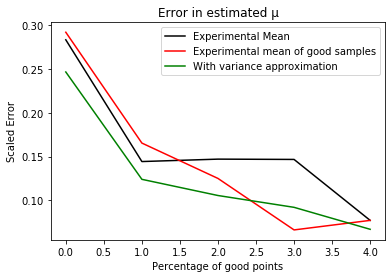

In [310]:
error_alg_20 = np.mean(np.absolute(alg_mean - mu)/mu, axis = 1)
error_exp_20 = np.mean(np.absolute(exp_mean - mu)/mu, axis = 1)
error_good_20 = np.mean(np.absolute(good_mean - mu)/mu, axis = 1)
error_second_20 = np.mean(np.absolute(second_alg - mu)/mu, axis = 1)


# plt.plot(error_alg_20, c = 'b', label="MPE")
plt.plot(error_exp_20, c = 'k', label="Experimental Mean")
plt.plot(error_good_20, c = 'r', label="Experimental mean of good samples")
plt.plot(error_second_20, c = 'g', label="With variance approximation")

plt.xlabel("Percentage of good points")
plt.ylabel("Scaled Error")
plt.title("Error in estimated \u03BC")

plt.legend(loc = "top right")




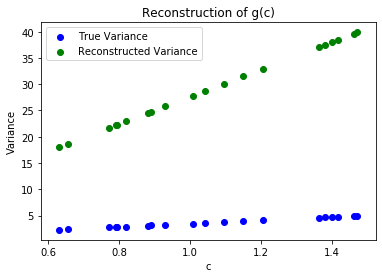

In [312]:
plt.scatter(C, sigma2, c='b', label = "True Variance")
plt.scatter(C, aproximation, c = 'g', label="Reconstructed Variance")
plt.xlabel("c")
plt.ylabel("Variance")
plt.title("Reconstruction of g(c)")
plt.legend(loc="upper left")